In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
image_size = (224, 224)
batch_size = 32
enhanced_train_ds = image_dataset_from_directory(
    "/kaggle/input/enhanced-images/Clahe_Images",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
enhanced_val_ds =image_dataset_from_directory(
    "/kaggle/input/enhanced-images/Clahe_Images",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

2024-06-03 09:06:59.674997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 09:06:59.675118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 09:06:59.774588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Found 1650 files belonging to 5 classes.
Using 330 files for validation.


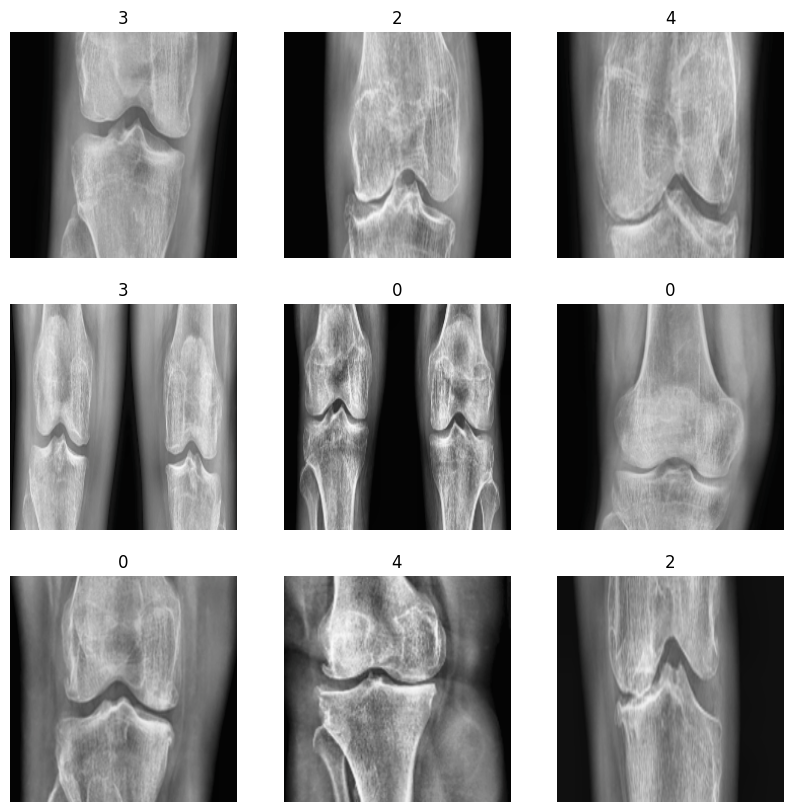

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in enhanced_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

input_shape = (224, 224, 3)
num_classes = 5  # Assuming 5 KL grades

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers[-10:]:  # Unfreezing last 10 layers, adjust as needed
    layer.trainable = True
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 58,219,520 (222.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [4]:
callbacks = [
    ModelCheckpoint("best_enhanced_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
]

# Train the model
history = model.fit(
    enhanced_train_ds,
    epochs=30,  # Adjust the number of epochs as needed
    validation_data=enhanced_val_ds,
#     class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1717405851.895259      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717405852.179220      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2797 - loss: 1.7450   

W0000 00:00:1717405963.867844      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.2811 - loss: 1.7413 - val_accuracy: 0.2121 - val_loss: 1.7467
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - accuracy: 0.5802 - loss: 1.0664 - val_accuracy: 0.3030 - val_loss: 1.5491
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step - accuracy: 0.7221 - loss: 0.7752 - val_accuracy: 0.4303 - val_loss: 1.3000
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.8340 - loss: 0.5649 - val_accuracy: 0.5091 - val_loss: 1.1625
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - accuracy: 0.8974 - loss: 0.4081 - val_accuracy: 0.5697 - val_loss: 1.0707
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - accuracy: 0.9301 - loss: 0.3133 - val_accuracy: 0.5879 - val_loss: 1.0390
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step - accuracy: 0.9486 - loss: 0.2459 - val_accuracy: 0.6030 - val_loss: 1.0016
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 513ms/step - accuracy: 0.9713 - loss: 0.1885 - val_accuracy: 0.6121 

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for the validation set
y_true = []
y_pred = []

for images, labels in enhanced_val_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


W0000 00:00:1717406569.965658      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Confusion Matrix:
[[82  8  1  7  0]
 [19 26  1  1  4]
 [ 1  4 27  0  5]
 [15  0  0 89  0]
 [ 1  3  2  0 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76        98
           1       0.63      0.51      0.57        51
           2       0.87      0.73      0.79        37
           3       0.92      0.86      0.89       104
           4       0.79      0.85      0.82        40

    accuracy                           0.78       330
   macro avg       0.78      0.76      0.76       330
weighted avg       0.79      0.78      0.78       330



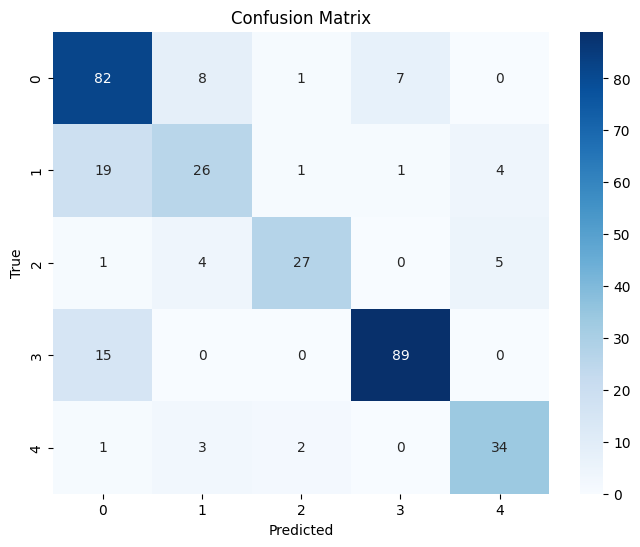


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76        98
           1       0.63      0.51      0.57        51
           2       0.87      0.73      0.79        37
           3       0.92      0.86      0.89       104
           4       0.79      0.85      0.82        40

    accuracy                           0.78       330
   macro avg       0.78      0.76      0.76       330
weighted avg       0.79      0.78      0.78       330



In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ... (Previous code)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))


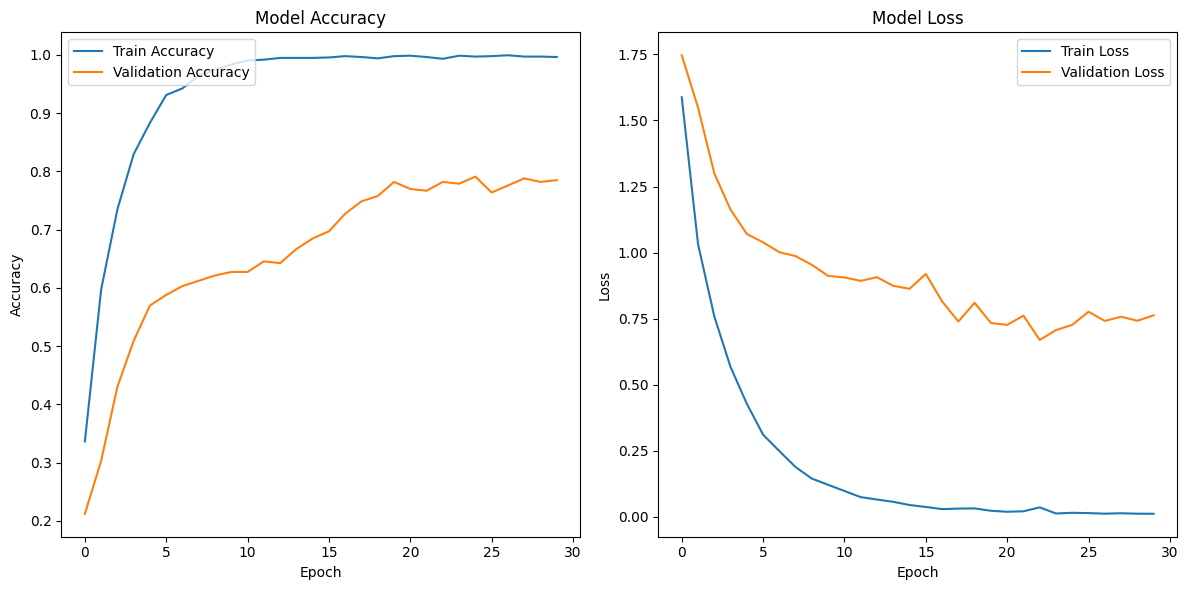

In [7]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

kl_grade_labels = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']

kl_descriptions = {
    'KL0': 'Normal',
    'KL1': 'Doubtful',
    'KL2': 'Mild',
    'KL3': 'Moderate',
    'KL4': 'Severe'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


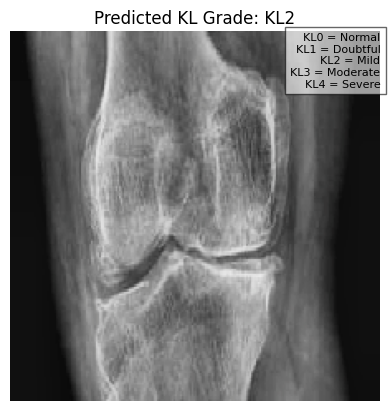

In [9]:
# Load and preprocess the image
img_path = '/kaggle/input/enhanced-test-ds/Enhanced_Test_Data/Copy of ModerateG3 (2).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


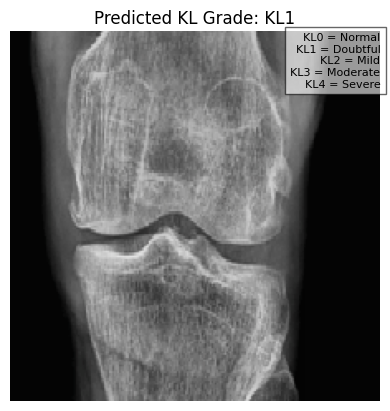

In [10]:
# Load and preprocess the image
img_path = '/kaggle/input/enhanced-test-ds/Enhanced_Test_Data/Copy of MildG2 (6).png'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


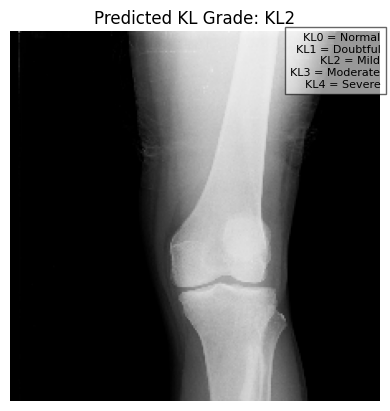

In [11]:
# Load and preprocess the image
img_path = '/kaggle/input/custom-ds/custom/58.jpg'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


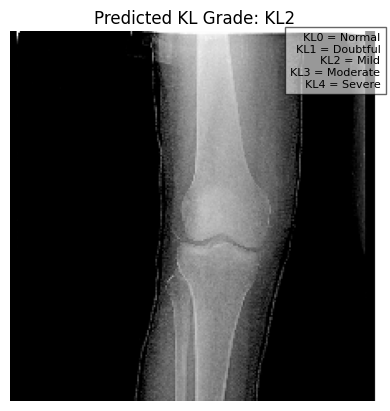

In [12]:
# Load and preprocess the image
img_path = '/kaggle/input/custom-ds/custom/96.jpg'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


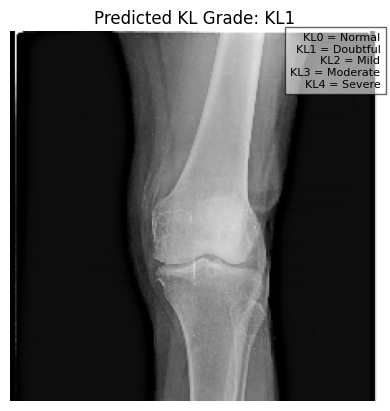

In [13]:
# Load and preprocess the image
img_path = '/kaggle/input/custom-ds/custom/95.jpg'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


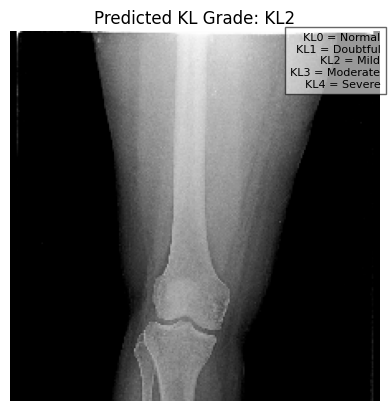

In [14]:
# Load and preprocess the image
img_path = '/kaggle/input/custom-ds/custom/27.jpg'
img = image.load_img(img_path, target_size=(224, 224))
#img = apply_clahe(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_probs = tf.nn.softmax(predictions)
predicted_class = np.argmax(predicted_probs, axis=1)[0]
predicted_kl_grade = kl_grade_labels[predicted_class]

# Display the image with the predicted KL grade
plt.imshow(img)
plt.title(f'Predicted KL Grade: {predicted_kl_grade}')
plt.axis('off')

# Add the severity scale in the upper right corner
scale_text = '\n'.join([f'{label} = {desc}' for label, desc in kl_descriptions.items()])
plt.text(224, 0, scale_text, fontsize=8, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

plt.show()

In [15]:
model.save('OA_Enhanced_model.keras')